## ResFPN Classifier Tutorial - Flower Photos

by *Ming Ming Zhang*

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

import resnet_fpn

In [2]:
dataset_dir = r'C:\Users\mingm\DeepLearning\datasets\flower_photos'

batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    batch_size=batch_size, 
    image_size=(256,256),
    shuffle=True, 
    seed=123,
    validation_split=0.1, 
    subset='training')

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir, 
    batch_size=batch_size, 
    image_size=(256,256), 
    shuffle=True, 
    seed=123, 
    validation_split=0.1, 
    subset='validation'
)

classes = train_ds.class_names
print(classes)

Found 3670 files belonging to 5 classes.
Using 3303 files for training.
Found 3670 files belonging to 5 classes.
Using 367 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [3]:
train_ds = train_ds.cache().shuffle(1000).prefetch(
    tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().prefetch(
    tf.data.experimental.AUTOTUNE)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

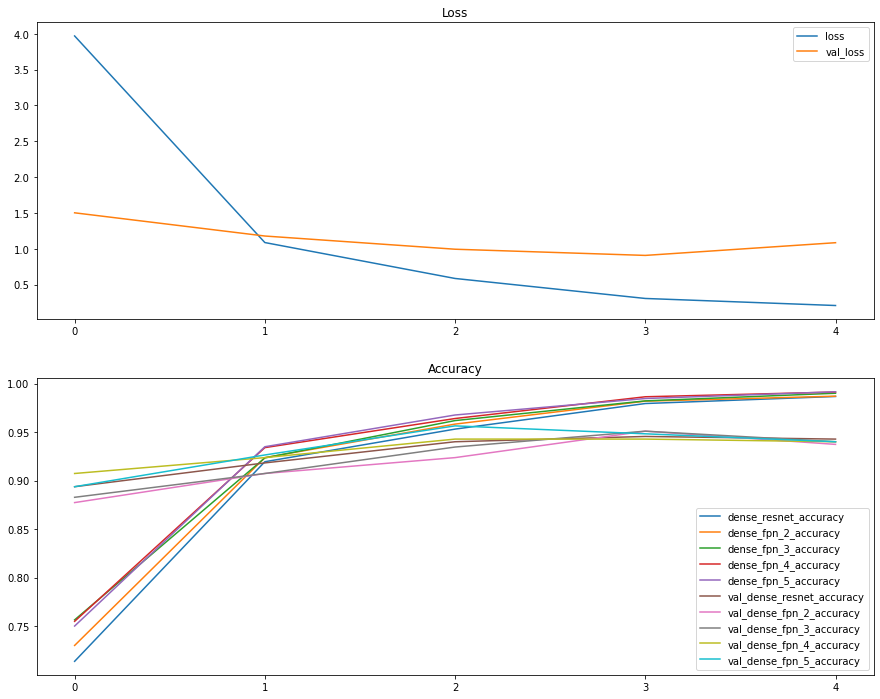

In [4]:
resnet_ws_dir = r'C:\Users\mingm\DeepLearning\resnet_weights'
resnet_ws_file = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet_ws_path = os.path.join(resnet_ws_dir, resnet_ws_file)

resfpn = resnet_fpn.ResFPN_Classifier(
    image_shape=(256,256,3), 
    num_classes=len(classes),
    architecture='resnet50', 
    augmentation=True, 
    train_bn=True,
    params={'lr':1e-3, 'l2':3e-1, 'epochs':5}, 
    loss_type='ce',
    save_weights=True,
    reduce_lr=True,
    resnet_weights_path=resnet_ws_path,
    multi_gpu_training=True,
    freeze_resnet=False
)

resfpn.train(
    train_ds, 
    val_ds
)

In [3]:
ckpt_dir = r'C:\Users\mingm\DeepLearning\ResFPN-main\model\checkpoints'
ckpt_file = '20210703-175256'
ckpt_path = os.path.join(ckpt_dir, ckpt_file, 'checkpoint')

# usually, require train_bn=False when inferencing; however, batch_size=64 is
# large and we only trained epochs=5, and so train_bn=True should be fine
resfpn = resnet_fpn.ResFPN_Classifier(
    image_shape=(256,256,3), 
    num_classes=len(classes),
    architecture='resnet50', 
    augmentation=True, 
    train_bn=True,
    checkpoint_path=ckpt_path
)


Loading checkpoint:
C:\Users\mingm\DeepLearning\ResFPN-main\model\checkpoints\20210703-175256\checkpoint



In [4]:
top_idxes, metrics = resfpn.select_top(val_ds, classes)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
6/6 [==============================] - 2s 284ms/step - loss: 0.9123 - dense_resnet_loss: 0.1711 - dense_fpn_2_loss: 0.1711 - dense_fpn_3_loss: 0.1910 - dense_fpn_4_loss: 0.1975 - dense_fpn_5_loss: 0.1817 - dense_resnet_accuracy: 0.9428 - dense_fpn_2_accuracy: 0.9537 - dense_fpn_3_accuracy: 0.9510 - dense_fpn_4_accuracy: 0.9510 - dense_fpn_5_accuracy: 0.9591

Top classifiers: 

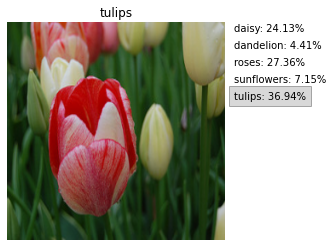

y_true=tulips vs y_pred=tulips


In [5]:
for x, y in val_ds.take(1):
    idx = np.random.randint(batch_size)
    image = x[idx]
    y_pred = resfpn.predict(image, top_idxes, classes)
    print('y_true=%s vs y_pred=%s' %(classes[y[idx]], classes[y_pred]))